# Converting ATLAS Electron Energy Regression Model to .h5 File for Use in TensorRT Acceleration

### Matthew Trahms (University of Washington ACME Lab)

This notebook goes through the steps required to convert the ATLAS Electron Energy regression model, perform inference, save it in a unified model and architecture file, then reload and reinfer from that new file as a sanity check. This will enable us to accelerate the model using NVidia TensorRT in the future.

In [4]:
import os
import sys
import json
import pickle
import joblib
import argparse
import numpy as np
import keras as ks
import deepcalo as dpcal
from keras.models import load_model
from keras.utils import plot_model

## File Locations

model_path is the location of the architecture json file

weights_path is the location of the weights hdf5 file

data_path is the path to the dataset h5 file

params_dir is the path to a file which selects which variables of the dataset should be loaded

save_path is the file where the resulting comprehensive model file will be saved and loaded from

In [2]:
model_path = 'C:\\Users\\mtrah\\deepcalo\\demos\\atlas_specific_usecases\\use_trained_model\\models\\model_ER_central_0-100GeV_photons_images_scalars\\saved_models\\model.json'
weights_path = 'C:\\Users\\mtrah\\deepcalo\\demos\\atlas_specific_usecases\\use_trained_model\\models\\model_ER_central_0-100GeV_photons_images_scalars\\saved_models\\weights.hdf5'
data_path = 'C:\\Users\mtrah\\Documents\\ACME\\Energy Regression Model\\MC_abseta_1.6_2.5_et_0.0_5000000.0_processes_energy.h5'
params_dir = 'models/model_ER_central_0-100GeV_photons_images_scalars/'
save_path = 'C:\\Users\\mtrah\\deepcalo\\demos\\atlas_specific_usecases\\use_trained_model\\models\\model_ER_central_0-100GeV_photons_images_scalars\\saved_models\\full.h5'
verbose = True

## Loading Data

In [26]:
n_points = {'train':1, 'test':1e2}

# Load data parameters associated with the model
with open(os.path.join(params_dir,'dataparams.pkl'), 'rb') as f:
    data_params = pickle.load(f)

data = dpcal.utils.load_atlas_data(data_path, n_points=n_points, **data_params, verbose=verbose)

# ======================================================
# Standardize scalar variables
# ======================================================
for name in data_params['scalar_names']:
    with open(os.path.join(params_dir,f'scalers/scaler_{name}.jbl'), 'rb') as f:
        scaler = joblib.load(f)

        var_ind = data_params['scalar_names'].index(name)
        for set_name in data:
            data[set_name]['scalars'][:,var_ind] = np.squeeze(scaler.transform(np.expand_dims(data[set_name]['scalars'][:,var_ind],1)))
            if verbose:
                print(f'Min and max of {name} in {set_name} set after standardization: '
                      f'{data[set_name]["scalars"][:,var_ind].min(), data[set_name]["scalars"][:,var_ind].max()}')

Loading data.
Loading only the 1 first data points of the train set.
Loading only the 100 first data points of the test set.
Data loaded.
Min and max of p_f0Cluster in train set after standardization: (1.0931750722910127, 1.0931750722910127)
Min and max of p_f0Cluster in test set after standardization: (-0.9614293430232357, 1.8901968094526205)
Min and max of p_R12 in train set after standardization: (0.866210245885569, 0.866210245885569)
Min and max of p_R12 in test set after standardization: (-1.658034848917636, 2.58750374167622)
Min and max of p_eAccCluster in train set after standardization: (0.6804644974415901, 0.6804644974415901)
Min and max of p_eAccCluster in test set after standardization: (-1.2337033910223385, 2.7897919942149887)
Min and max of p_cellIndexCluster in train set after standardization: (0.44680851063829785, 0.44680851063829785)
Min and max of p_cellIndexCluster in test set after standardization: (0.40425531914893614, 1.148936170212766)
Min and max of p_eta in trai

C:\Users\mtrah\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mtrah\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mtrah\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator QuantileTransformer from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\mtrah\Anaconda3\lib\site-packages\sklearn\base.py:306: UserWarning: Trying to unpickle estimator RobustScaler from version 0.20.3 when using version 0.21.3. This might lead to breaking code or invalid r

## Loading Model (JSON)

In [3]:
# ======================================================
# Load model
# ======================================================
# Model reconstruction from JSON
# We need to include the custom FiLM layer, as implemented in DeepCalo.
with open(model_path, 'r') as model_json:
    arch = json.load(model_json)
    json_model = ks.models.model_from_json(arch, custom_objects={'FiLM': dpcal.layers.FiLM()})
if verbose:
    print(f'Model architecture loaded from {model_path}.')

# Inspect the structure of the model
json_model.summary()

# Load weights
json_model.load_weights(weights_path)
if verbose:
    print(f'Weights loaded from {weights_path}.')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model architecture loaded from C:\Users\mtrah\deepcalo\demos\atlas_specific_usecases\use_trained_model\models\model_ER_central_0-100GeV_photons_images_scalars\saved_models\model.json.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
em_barrel (InputLayer)          (None, 56, 11, 4)    0                                            
__________________________________________________________________________________________________
scalars (InputLayer)            (None, 11)           0                                            
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 56, 55, 4)    0           em_barrel[0][0]                  
________________________

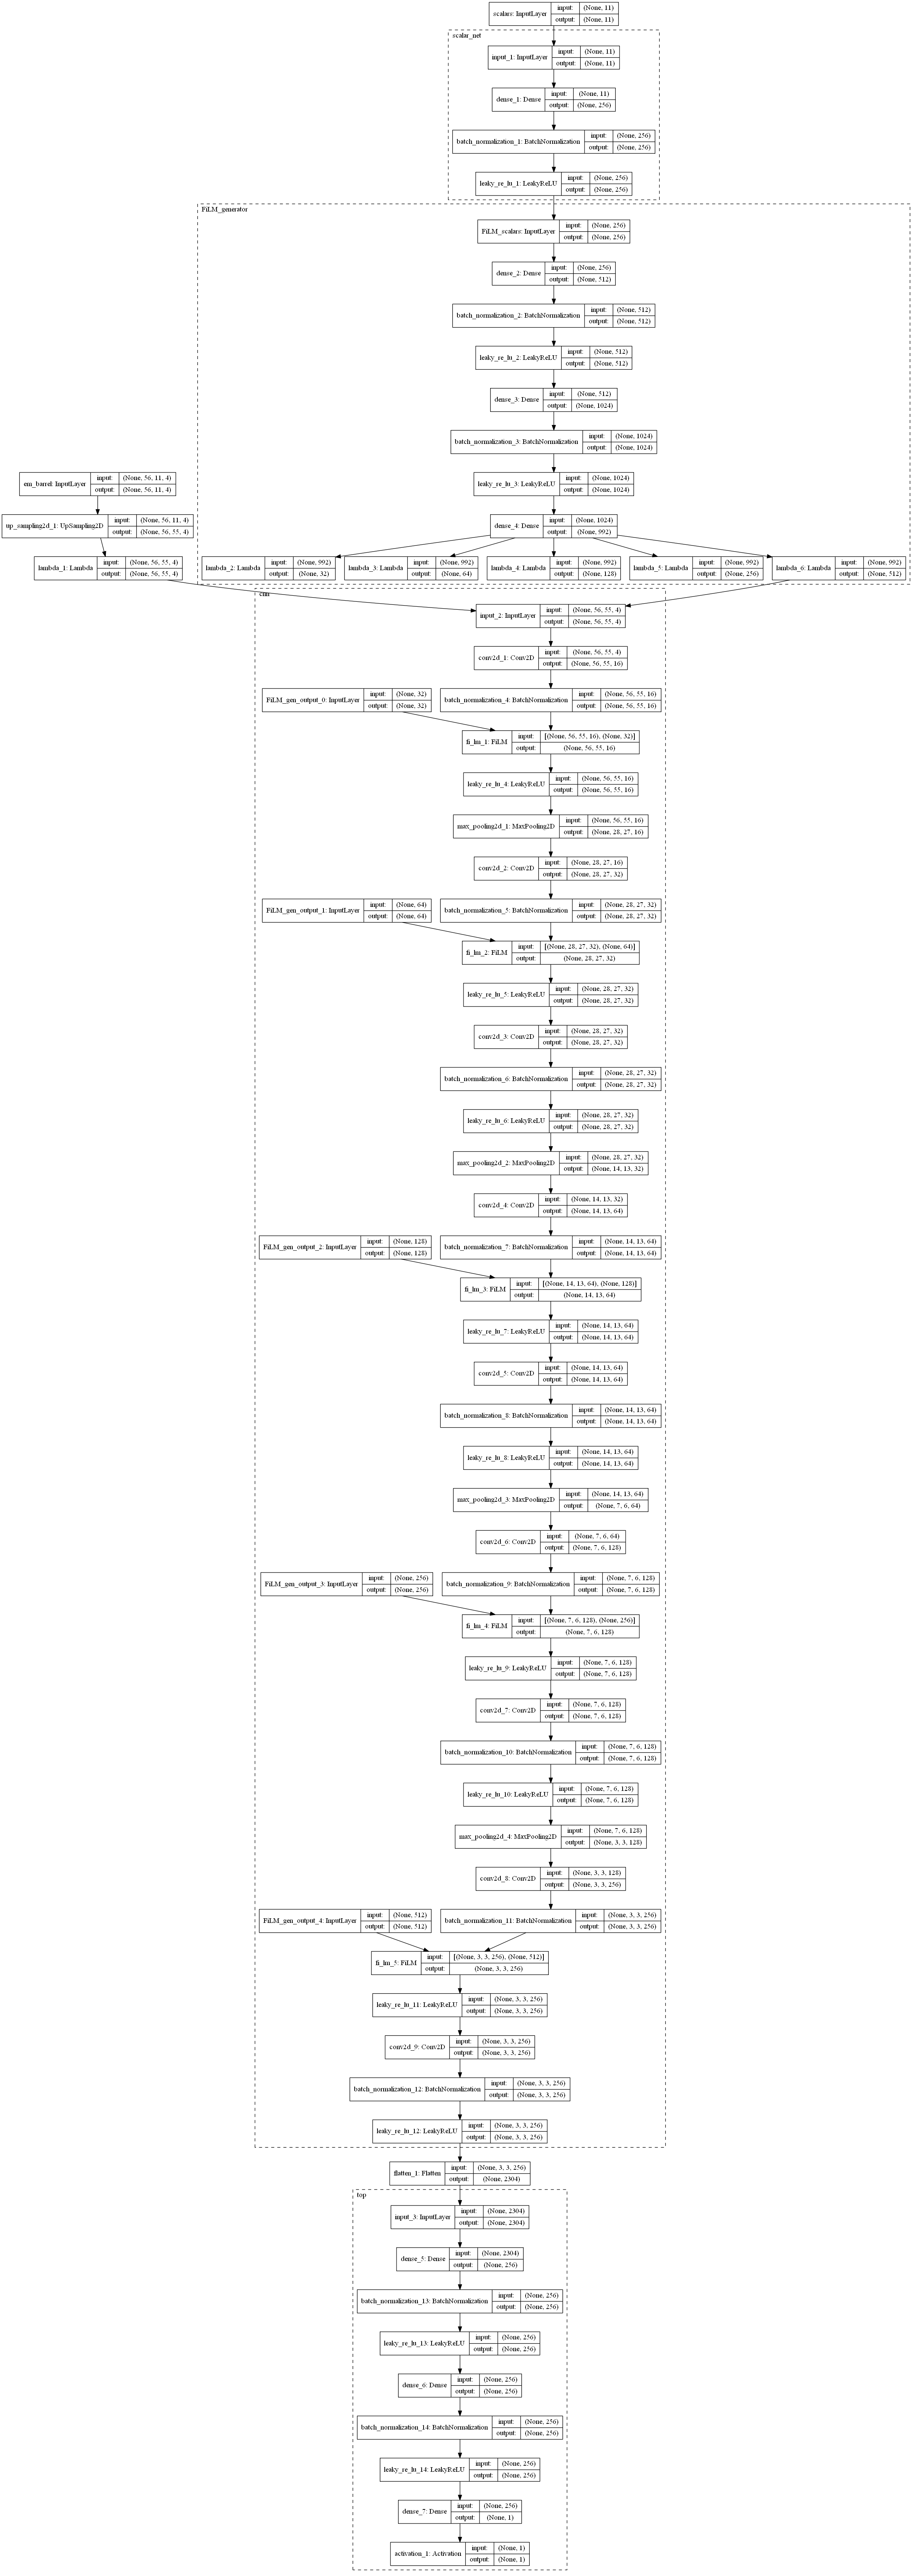

In [5]:
plot_model(json_model, show_shapes=True, expand_nested=True)

## Model Inference (JSON)

In [28]:
if verbose:
    print('Predicting.')

# Choose which set to predict on
pred_set = 'test'

# Organize input data
# It is essential that inputs are added in this order, as it is what the loaded
# model expects.
inputs = []
expected = []

# Images
if 'images' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['images']):
    for img_name in data[pred_set]['images']:
        inputs.append(data[pred_set]['images'][img_name])

# Scalars
if 'scalars' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['scalars']):
    inputs.append(data[pred_set]['scalars'])

# Tracks
if 'tracks' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['tracks']):
    inputs.append(data[pred_set]['tracks'])

# Multiply output with
if 'multiply_output_with' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['multiply_output_with']):
    inputs.append(data[pred_set]['multiply_output_with'])

# Predict
preds = json_model.predict(inputs).flatten()
truths = data[pred_set]['targets']
error = np.mean(np.absolute(truths-preds))

if verbose:
    print('Predictions:')
    print(preds)
    print('expected: ')
    print(truths)
    print('error:')
    print(error)

Predicting.
Predictions:
[134.97731  127.08551   93.803665 147.86182  185.45041  111.74098
 177.38081  111.29251  125.716835 171.7916    65.47895   79.238434
 118.22186  259.1008    48.13835  118.759735 138.70921  167.74124
 103.714386 160.02496   74.58809  146.65123  188.0611   193.37604
 148.44772   47.956593 201.09491  133.44542  389.10672  148.05994
 114.950836 108.89866  125.93683   37.46375  121.3808   160.98529
 112.14303  135.85516   99.00746  228.86531  212.38747  126.39606
 116.28104   48.359337 139.82199  116.587265  79.39441  293.763
  64.36051  225.4978   133.18266   85.903824 176.4765   125.18681
 156.1539   312.7441   101.47975  113.3188   157.74162  136.66504
 102.97899  140.62665   54.92972  120.47223  131.54364   73.57868
 129.31883  158.00192  136.90732  121.64662  148.77875  156.6805
 122.62255  135.23444   53.29138  189.13272  102.337036 122.190796
  95.07353   66.26167  137.69196  166.57364  146.84697   94.38071
 184.58691   93.345505 101.24969  102.41614   65.794

## Save Model as .h5 File

In [29]:
json_model.save(save_path)

## Delete JSON Model

In [ ]:
del json_model

## Reload Model from .h5 and Perform Inference
This is done to ensure that the model still functions correctly and to provide a reference for how the .h5 file should be loaded through Keras

In [31]:
full_model = load_model(save_path, custom_objects={'FiLM': dpcal.layers.FiLM()})

if verbose:
    print('Predicting.')

# Choose which set to predict on
pred_set = 'test'

# Organize input data
# It is essential that inputs are added in this order, as it is what the loaded
# model expects.
inputs = []
expected = []

# Images
if 'images' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['images']):
    for img_name in data[pred_set]['images']:
        inputs.append(data[pred_set]['images'][img_name])

# Scalars
if 'scalars' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['scalars']):
    inputs.append(data[pred_set]['scalars'])

# Tracks
if 'tracks' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['tracks']):
    inputs.append(data[pred_set]['tracks'])

# Multiply output with
if 'multiply_output_with' in data[pred_set] and dpcal.utils.boolify(data[pred_set]['multiply_output_with']):
    inputs.append(data[pred_set]['multiply_output_with'])

# Predict
preds = full_model.predict(inputs).flatten()
truths = data[pred_set]['targets']
error = np.mean(np.absolute(truths-preds))

if verbose:
    print('Predictions:')
    print(preds)
    print('expected: ')
    print(truths)
    print('error:')
    print(error)

C:\Users\mtrah\Anaconda3\lib\site-packages\keras-2.3.1-py3.7.egg\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Predicting.
Predictions:
[134.97731  127.08551   93.803665 147.86182  185.45041  111.74098
 177.38081  111.29251  125.716835 171.7916    65.47895   79.238434
 118.22186  259.1008    48.13835  118.759735 138.70921  167.74124
 103.714386 160.02496   74.58809  146.65123  188.0611   193.37604
 148.44772   47.956593 201.09491  133.44542  389.10672  148.05994
 114.950836 108.89866  125.93683   37.46375  121.3808   160.98529
 112.14303  135.85516   99.00746  228.86531  212.38747  126.39606
 116.28104   48.359337 139.82199  116.587265  79.39441  293.763
  64.36051  225.4978   133.18266   85.903824 176.4765   125.18681
 156.1539   312.7441   101.47975  113.3188   157.74162  136.66504
 102.97899  140.62665   54.92972  120.47223  131.54364   73.57868
 129.31883  158.00192  136.90732  121.64662  148.77875  156.6805
 122.62255  135.23444   53.29138  189.13272  102.337036 122.190796
  95.07353   66.26167  137.69196  166.57364  146.84697   94.38071
 184.58691   93.345505 101.24969  102.41614   65.794